In [1]:

path = "npatlas/npatlas.json"
import json
with open(path, 'r') as f:
    objs = json.load(f)
    
len(objs)

36454

In [2]:
assert all("smiles" in obj for obj in objs)

In [3]:
distinct_structures = set(obj["smiles"] for obj in objs)

In [4]:
len(distinct_structures)

36434

793

In [45]:
from copy import copy


def flatten_entry(entry: dict):
    flattened = copy(entry)
    #flattened["classyfire_class_name"] = entry["classyfire"]["class"]["name"]
    cf = entry.get("classyfire", {})
    if cf:
        cf_class = cf.get("class", {})
        if cf_class:
            flattened["classyfire_class_name"] = cf_class.get("name")
    return flattened
    
flattened_entries = [flatten_entry(obj) for obj in objs]

In [56]:
entries_no_cf = [e for e in flattened_entries if "classyfire_class_name" not in e or not e["classyfire_class_name"]]
len(entries_no_cf)

793

In [46]:
import pandas as pd
entries_df = pd.DataFrame(flattened_entries)
entries_df

,id,npaid,original_name,mol_formula,mol_weight,exact_mass,inchikey,smiles,cluster_id,node_id,...,m_plus_na,origin_reference,origin_organism,syntheses,reassignments,mol_structures,external_ids,classyfire,npclassifier,classyfire_class_name
0,1,NPA000001,Curvularide C,C19H37NO5,359.5070,359.2672,BZLIDAVUQDTJQF-HWTFSWDCSA-N,CC[C@H](C)[C@@H](CO)NC(=O)/C=C/[C@](C)([C@H]([...,1,1,...,382.2564,"{'doi': '10.1002/chem.201000652', 'pmid': 2068...","{'id': 1, 'type': 'Fungus', 'genus': 'Curvular...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Open...",Fatty Acyls
1,2,NPA000002,Homopetasinic acid,C24H32O6,416.5140,416.2199,MMWCHIIGAIJQMV-DHCANEKFSA-N,C[C@H]1[C@@H](CCC2=CC(=O)[C@@H](C[C@]12C)C(=C)...,2,2,...,439.2091,"{'doi': '10.1016/j.tetlet.2016.01.095', 'pmid'...","{'id': 2, 'type': 'Fungus', 'genus': 'Diaporth...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Erem...",Prenol lipids
2,3,NPA000003,A-503083 F,C18H22N4O13,502.3890,502.1183,RNRCUOCMUNIOMZ-UHFFFAOYSA-N,COC1C(C(OC1C(C(=O)N)OC2C(C(C=C(O2)C(=O)O)O)O)N...,3,3,...,525.1075,"{'doi': '10.7164/antibiotics.57.639', 'pmid': ...","{'id': 3, 'type': 'Bacterium', 'genus': 'Strep...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'mibig', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': True, 'class_results': ['Pyrim...",Organooxygen compounds
3,4,NPA000004,Aqabamycin E2,C16H11N3O5,325.2800,325.0699,NMMDNCZQLOFGES-UHFFFAOYSA-N,C1=CC=C(C=C1)C2=C(NC(=C2C3=CC(=C(C=C3)O)[N+](=...,4,4,...,348.0591,"{'doi': '10.1038/ja.2010.34', 'pmid': 20431617...","{'id': 4, 'type': 'Bacterium', 'genus': 'Vibri...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': [], 'p...",Pyrroles
4,5,NPA000005,Hymenopsin A,C22H32O6,392.4920,392.2199,OYLVOLOSQHRPLK-WRXMSMRBSA-N,C[C@]1(CCC[C@]2([C@H]1CC=C3[C@@H]2C[C@]45C(O4)...,5,5,...,415.2091,"{'doi': '10.1021/np900613d', 'pmid': 19928955,...","{'id': 5, 'type': 'Fungus', 'genus': 'Fusarium...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Abeo...",Prenol lipids
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36449,36718,NPA036718,Julichrome Q3-3,C38H38O16,750.7060,750.2160,FCANTWZHYAQEKU-DLUJSSSPSA-N,CC(=O)O[C@H](C)[C@H]1[C@@](C)(O)CC(=O)[C@]23O[...,1472,1213,...,773.2052,"{'doi': '10.1021/ja501630w', 'pmid': 24746278,...","{'id': 11501, 'type': 'Bacterium', 'genus': 'S...",[],"[{'reference_doi': '10.1002/cbdv.202000057', '...","[{'current_structure': False, 'reference_doi':...","[{'external_db_name': 'gnps', 'external_db_cod...",None,None,NaN
36450,36719,NPA036719,GE81112A,C24H34ClN9O10,644.0420,643.2117,MPRVLYUMDIXCGD-UHFFFAOYSA-N,NC(=O)OCC(O)CC(NC(=O)C1NCCCC1O)C(=O)NC(CC1=CN=...,2001,1606,...,666.2009,"{'doi': '10.1021/bi052540k', 'pmid': 16533052,...","{'id': 3898, 'type': 'Bacterium', 'genus': 'St...",[],[],"[{'current_structure': True, 'reference_doi': ...",[],None,None,NaN
36451,36723,NPA036723,Subvellerolactone C,C17H26O5,310.3900,310.1780,KJKLEJNFKHFYGR-PDROMXSDSA-N,CC[C@]1(O)OC(=O)C2=C1[C@H](O)[C@@H]1CC(C)(C)C[...,10508,28,...,333.1672,"{'doi': '10.5281/zenodo.13381755', 'pmid': Non...","{'id': 3861, 'type': 'Fungus', 'genus': 'Lacta...",[],[],"[{'current_structure': True, 'reference_doi': ...",[],None,None,NaN
36452,36726,NPA036726,10E-cyclonerotriol,C15H28O3,256.3860,256.2038,QGUPPGVBDCWDSK-BSYVWGKESA-N,C/C(=C\CC[C@@](C)(O)[C@@H]1CC[C@@]

In [5]:
from c3p.classifier import Classifier
from c3p.chebi_classifier import ChEBIClassifier

c3p_classifier = Classifier()
chebi_classifier = ChEBIClassifier()

In [6]:
def classify_all(classifier, structures):
    n = 0
    results = []
    for r in classifier.classify_iter(structures):
        if r.is_match:
            results.append(r)
            n += 1
            if n % 1000 == 0:
                print(n)
       
    print(len(results))
    return results
    

        

In [7]:
c3p_results = classify_all(c3p_classifier, distinct_structures)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


Error running is_bioconjugate in bioconjugate: 1 validation error for ClassificationResult
is_match
  Input should be a valid boolean [type=bool_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.10/v/bool_type


15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000


Error running is_4__hydroxyflavanones in 4__hydroxyflavanones: 1 validation error for ClassificationResult
is_match
  Input should be a valid boolean [type=bool_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.10/v/bool_type


138000
139000
140000
141000
142000
143000
144000
145000
146000
146883


In [9]:
len(c3p_results)

146883

In [10]:
!mkdir -p npatlas

In [12]:
import pandas as pd
c3p_df = pd.DataFrame( [r.model_dump() for r in c3p_results] )
c3p_df

,input_smiles,class_id,class_name,is_match,reason,confidence
0,CC(C)CCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCC(COP(=O)...,CHEBI:17517,phosphatidylglycerol,True,Contains glycerol backbone with 2 fatty acid c...,0.913408
1,CC(=O)OCCCCC/C=C\C[C@@]\1(C=CC(=O)/C1=C/C=C\[C...,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000
2,CCCCC/C=C\CC\1(C=C(C(=O)/C1=C/C=C/CCCC(=O)OC)Cl)O,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000
3,C[C@H](CC1=C([C@@]([C@@H](C1=O)NC(=O)CO)(C(=O)...,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000
4,CCCCC/C=C\CC\1(C=C(C(=O)/C1=C\C=C\CCCC(=O)OC)Cl)O,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000
...,...,...,...,...,...,...
146878,CC1=C(C2=C(C(=C1Cl)O)C(=O)C3=C(O2)C=C(C=C3C(=O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749
146879,CC1=CC(=CC2=C1C3=CC(=CC(=C3C(=O)O2)O)OS(=O)(=O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749
146880,CC(=CCC1=CC(=C2C(=C1O)C(=O)C3=CC(=CC(=C3O2)O)O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749
146881,CC1=C(C=C2C(=C1)OC3=C(C=C(C(=C3C2=O)C)C4=CC(=C...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749


In [13]:
c3p_df.to_csv("npatlas/c3p_results.csv")


In [27]:
c3p_df["class_name"].value_counts()

class_name
diterpenoid                            18926
diol                                    8724
phenylpropanoid                         8711
icosanoid                               8411
semisynthetic derivative                5531
                                       ...  
straight-chain saturated fatty acid        1
tetrachlorobenzene                         1
polyprenol phosphate                       1
aliphatic aldoxime                         1
phosphatidylglycerol                       1
Name: count, Length: 269, dtype: int64

In [14]:
len(chebi_classifier.smiles_to_parent_classes)

185103

In [16]:
chebi_results = classify_all(chebi_classifier, list(distinct_structures))

1000
1527


In [17]:
len(chebi_results)

1527

In [19]:
from c3p.clients.chebifier import ChebifierClient

chebifier = ChebifierClient()
chebifier_results = {}


In [23]:
for s in distinct_structures:
    if s not in chebifier_results:
        chebifier_results[s] = chebifier.classify(s)

HTTPError: 502 Server Error: Bad Gateway for url: https://chebifier.hastingslab.org/api/classify

In [22]:
len(chebifier_results) / len(distinct_structures)

0.7312400505022781

In [32]:
list(chebifier_results.values())[0]

[ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[C@]3(CC[C@@H]4[C@]5(CC[C@@H](C([C@@H]5CC[C@]4([C@@H]3C2)C)(C)C)OC(=O)C)C)C', class_id='CHEBI:25806', class_name='oxygen molecular entity', is_match=True, reason=None, confidence=1.0),
 ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[C@]3(CC[C@@H]4[C@]5(CC[C@@H](C([C@@H]5CC[C@]4([C@@H]3C2)C)(C)C)OC(=O)C)C)C', class_id='CHEBI:33308', class_name='carboxylic ester', is_match=True, reason=None, confidence=1.0),
 ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[C@]3(CC[C@@H]4[C@]5(CC[C@@H](C([C@@H]5CC[C@]4([C@@H]3C2)C)(C)C)OC(=O)C)C)C', class_id='CHEBI:25367', class_name='molecule', is_match=True, reason=None, confidence=1.0),
 ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[C@]3(CC[C@@H]4[C@]5(CC[C@@H](C([C@@H]5CC[C@]4([C@@H]3C2)C)(C)C)OC(=O)C)C)C', class_id='CHEBI:24532', class_name='organic heterocyclic compound', is_match=True, reason=None, confidence=1.0),
 ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[

In [33]:
chebifier_df = pd.DataFrame( [r.model_dump() for rs in chebifier_results.values() for r in rs] )

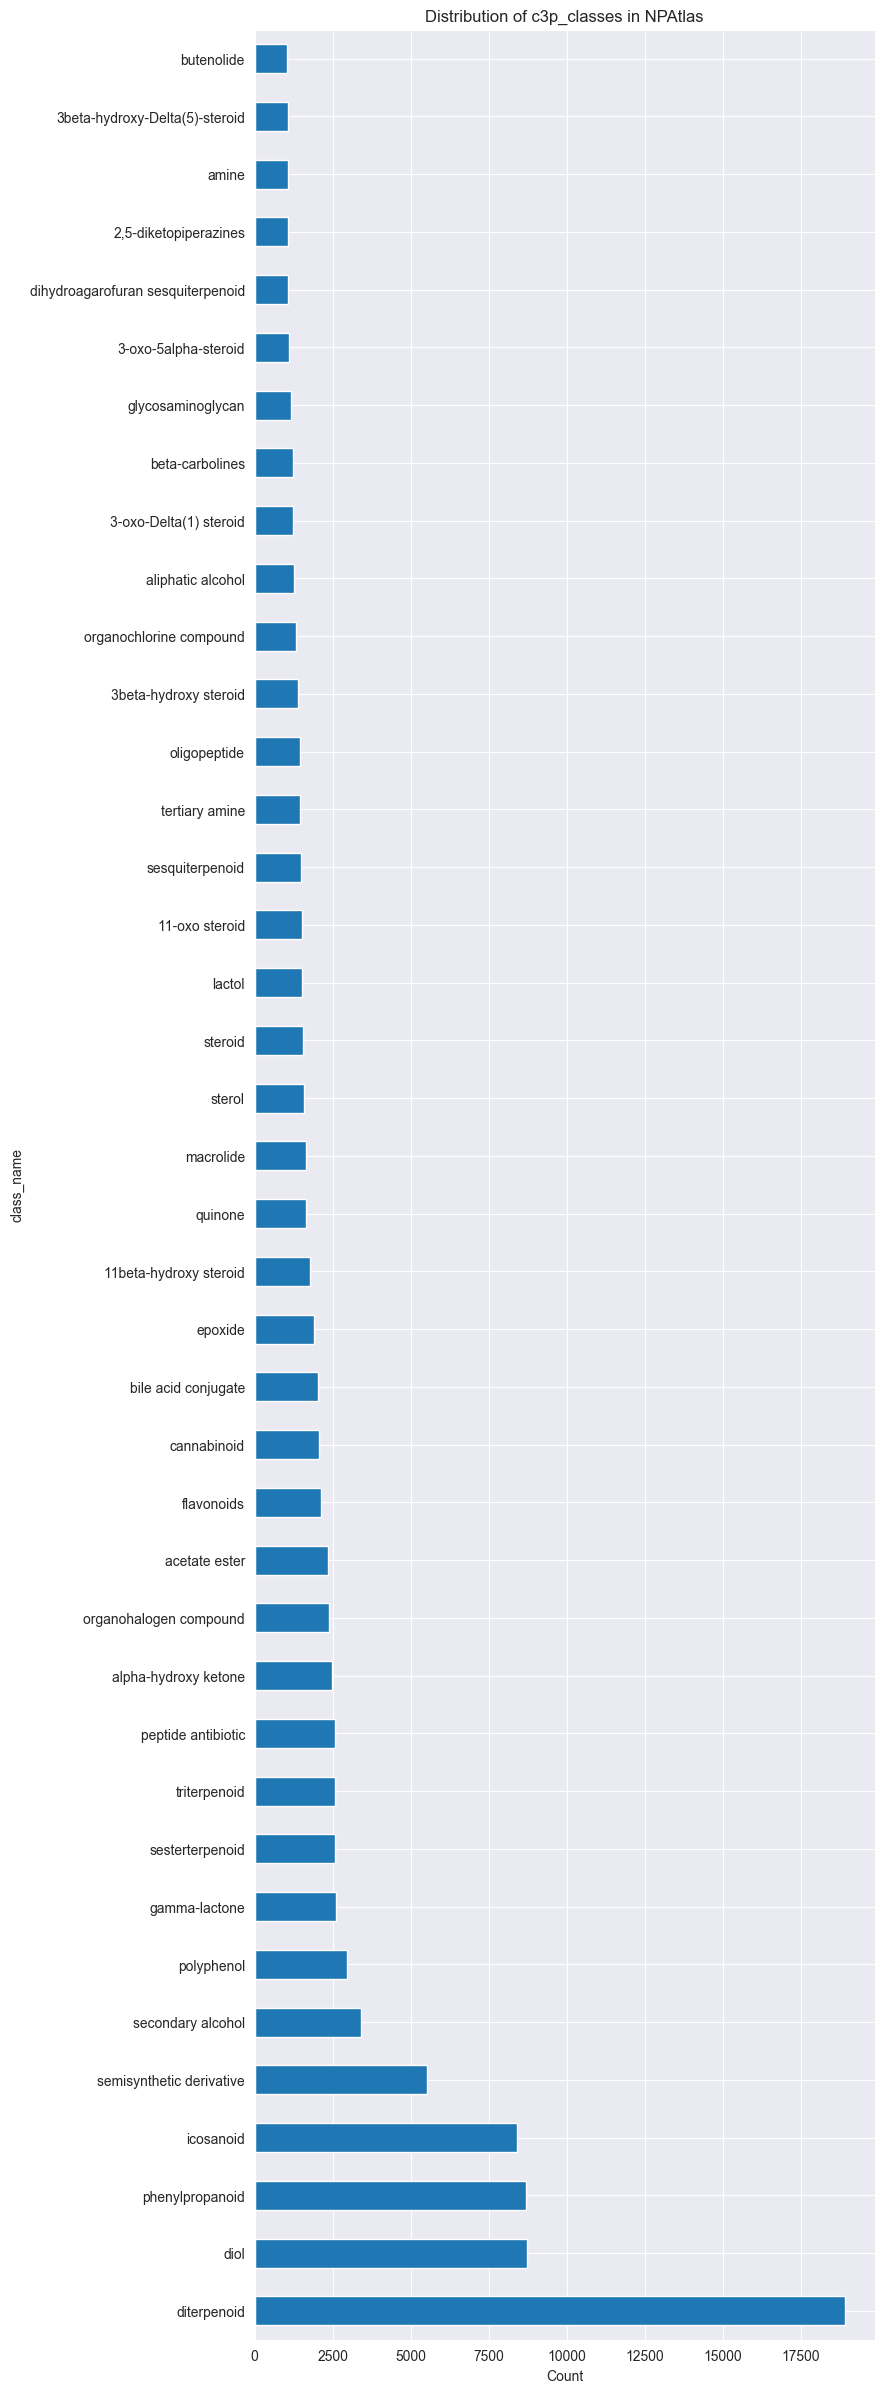

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_distribution(df, column_name="class_name", title=None, min_count=1000):
    
    
    
    # Count occurrences of each class
    class_counts = df[column_name].value_counts()
    # filter to be at least N
    class_counts = class_counts[class_counts > min_count]
    
    # Re-plot the bar chart with c3p_classes on y-axis (horizontal bar chart)
    plt.figure(figsize=(8, 30))
    class_counts.plot(kind='barh')
    plt.ylabel(column_name)
    plt.xlabel("Count")
    plt.title(title)
    plt.show()

plot_class_distribution(c3p_df, column_name="class_name", title="Distribution of c3p_classes in NPAtlas")

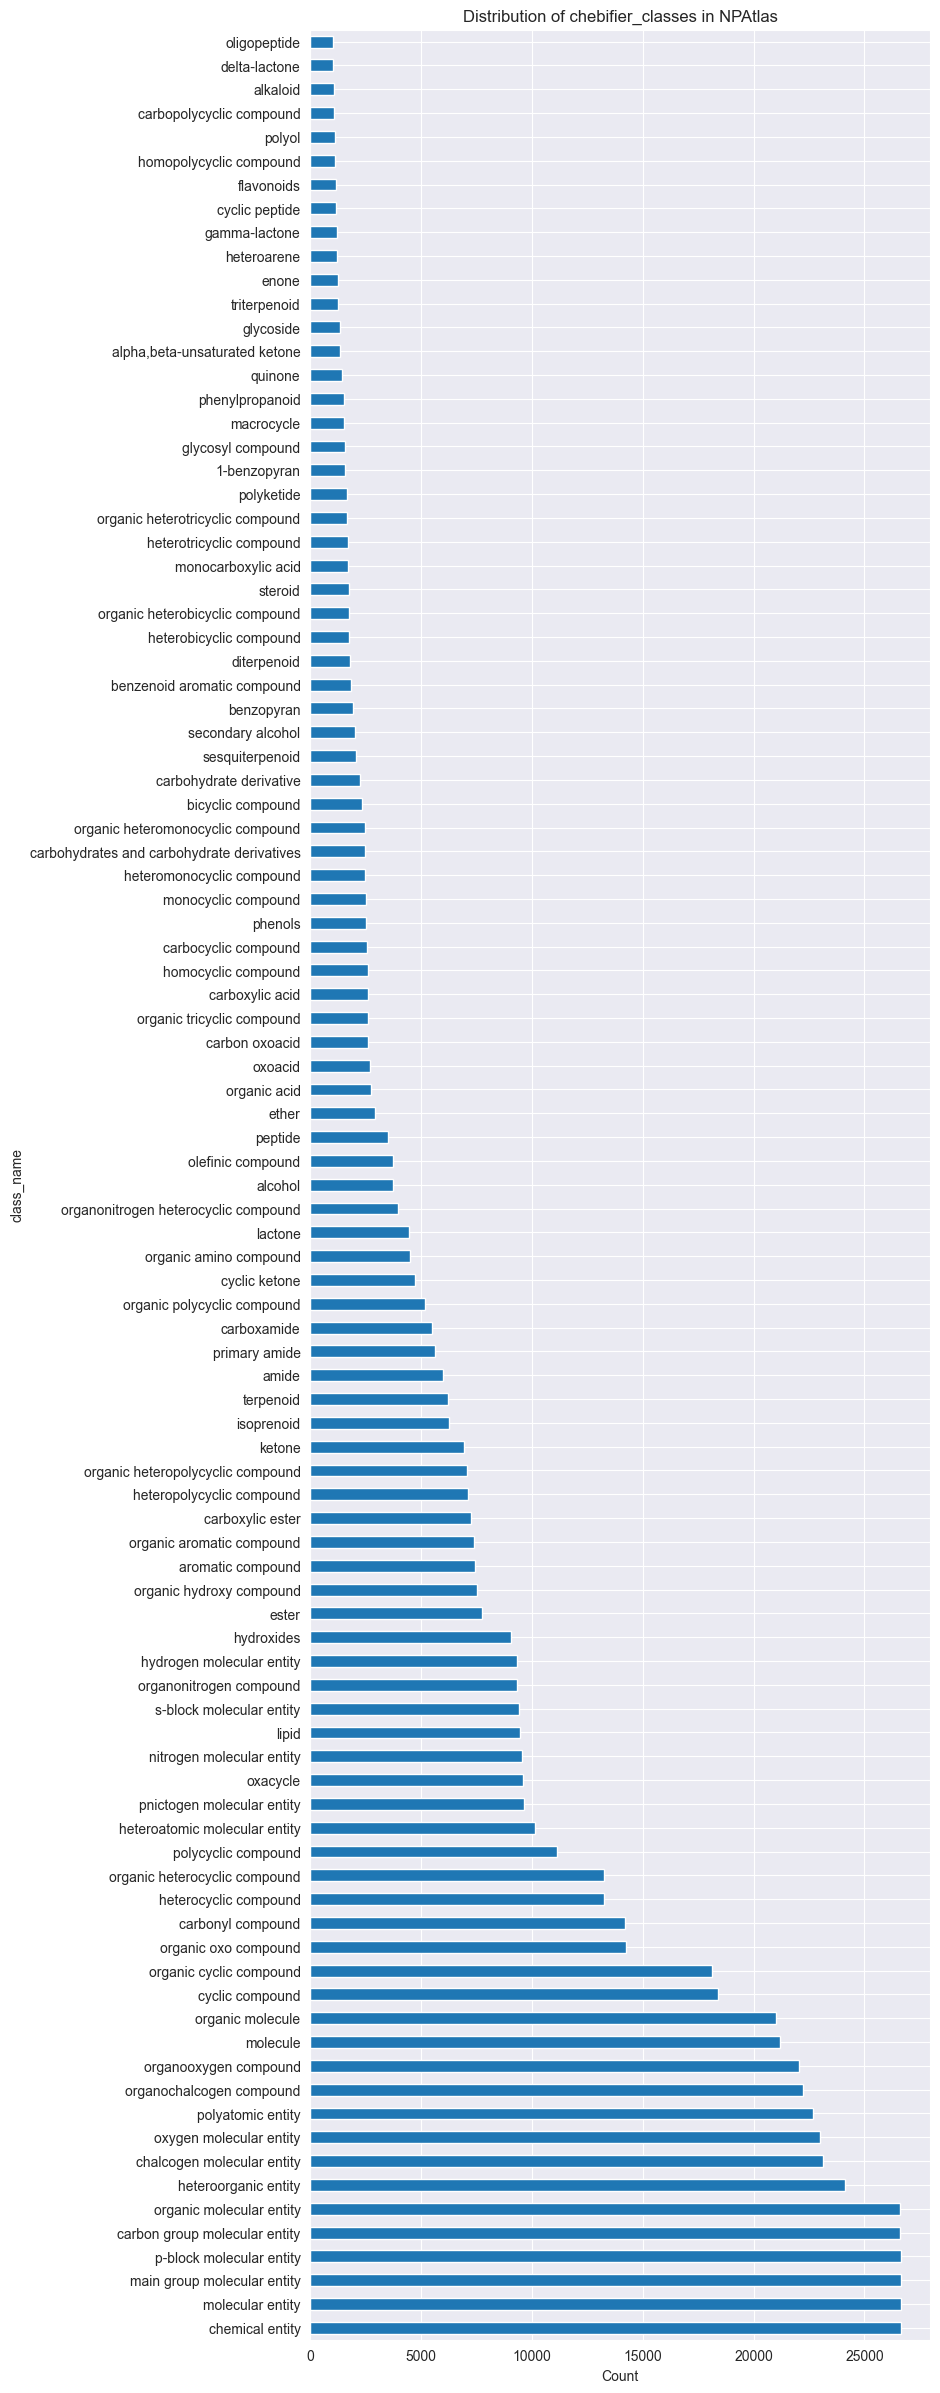

In [34]:
plot_class_distribution(chebifier_df, column_name="class_name", title="Distribution of chebifier_classes in NPAtlas")


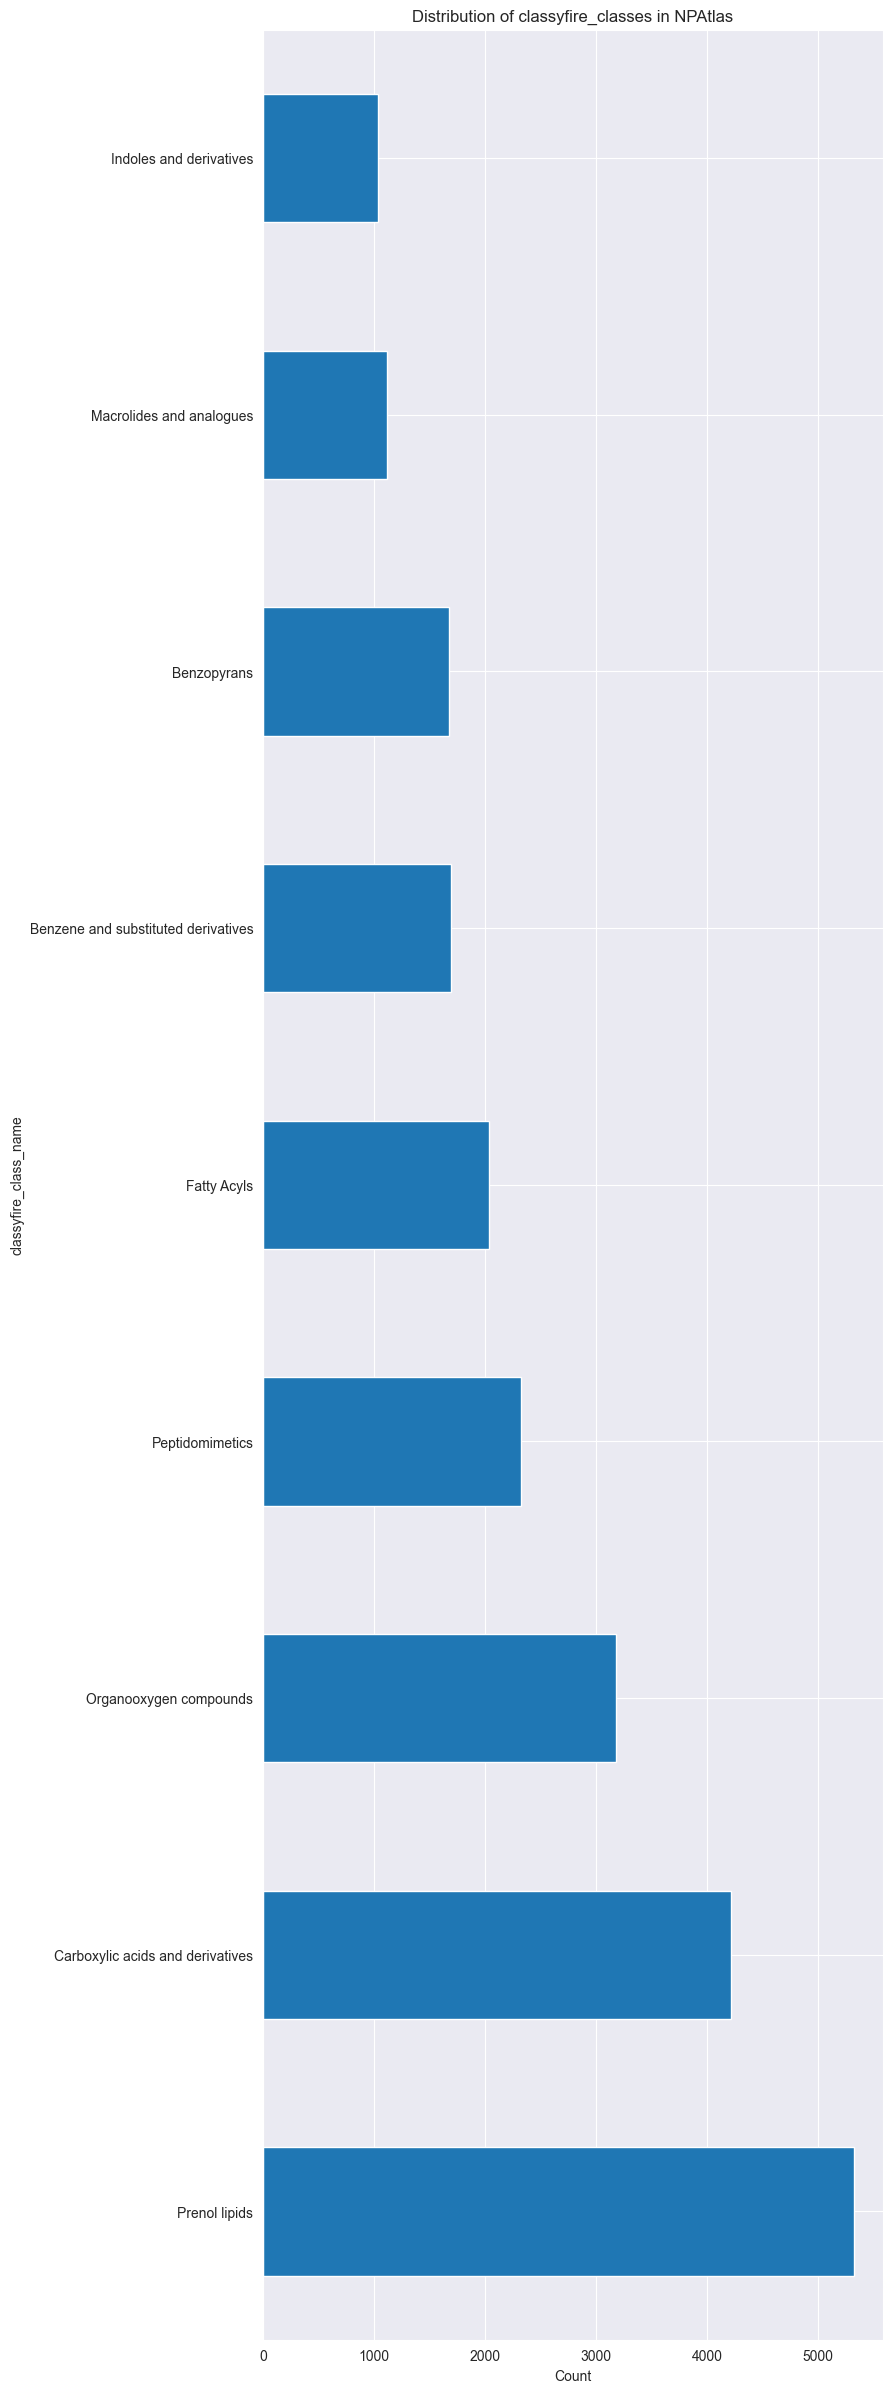

In [47]:
plot_class_distribution(entries_df, column_name="classyfire_class_name", title="Distribution of classyfire_classes in NPAtlas")

In [50]:
def merge_classifications_df(entries_df, df, renamed_column="c3p_class_name"):
    df2 = df.rename(columns={"class_name": renamed_column})
    joined = df2.merge(entries_df, left_on="input_smiles", right_on="smiles")
    # compare the two columns
    return joined


merged_df = merge_classifications_df(entries_df, c3p_df)
merged_df
    

,input_smiles,class_id,c3p_class_name,is_match,reason,confidence,id,npaid,original_name,mol_formula,...,m_plus_na,origin_reference,origin_organism,syntheses,reassignments,mol_structures,external_ids,classyfire,npclassifier,classyfire_class_name
0,CC(C)CCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCC(COP(=O)...,CHEBI:17517,phosphatidylglycerol,True,Contains glycerol backbone with 2 fatty acid c...,0.913408,825,NPA000825,DPG,C69H134O17P2,...,1319.8988,"{'doi': '10.1021/np990313b', 'pmid': 10843572,...","{'id': 368, 'type': 'Bacterium', 'genus': 'Mic...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Glyc...",Glycerophospholipids
1,CC(=O)OCCCCC/C=C\C[C@@]\1(C=CC(=O)/C1=C/C=C\[C...,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000,14701,NPA014701,Not named,C27H36O9,...,527.2251,"{'doi': '10.1016/s0040-4039(00)85917-1', 'pmid...","{'id': 3983, 'type': 'Fungus', 'genus': 'Clavu...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Clav...",Fatty Acyls
2,CCCCC/C=C\CC\1(C=C(C(=O)/C1=C/C=C/CCCC(=O)OC)Cl)O,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000,5289,NPA005289,Chlorovulone II,C21H29ClO4,...,403.1646,"{'doi': '10.1016/s0040-4039(00)98927-5', 'pmid...","{'id': 76, 'type': 'Fungus', 'genus': 'Clavula...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Clav...",Fatty Acyls
3,C[C@H](CC1=C([C@@]([C@@H](C1=O)NC(=O)CO)(C(=O)...,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000,24358,NPA024358,Mccrearamycin D,C33H50N2O14,...,721.3154,"{'doi': '10.1002/anie.201612447', 'pmid': 2814...","{'id': 8552, 'type': 'Bacterium', 'genus': 'St...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Open...",Fatty Acyls
4,CCCCC/C=C\CC\1(C=C(C(=O)/C1=C\C=C\CCCC(=O)OC)Cl)O,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000,15407,NPA015407,Chlorovulone III,C21H29ClO4,...,403.1646,"{'doi': '10.1016/s0040-4039(00)98927-5', 'pmid...","{'id': 76, 'type': 'Fungus', 'genus': 'Clavula...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Clav...",Fatty Acyls
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146946,CC1=C(C2=C(C(=C1Cl)O)C(=O)C3=C(O2)C=C(C=C3C(=O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749,8373,NPA008373,Penicillixanthone,C16H10Cl2O6,...,390.9746,"{'doi': '10.1016/j.tet.2014.05.105', 'pmid': N...","{'id': 124, 'type': 'Fungus', 'genus': 'Penici...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Meth...",Benzopyrans
146947,CC1=CC(=CC2=C1C3=CC(=CC(=C3C(=O)O2)O)OS(=O)(=O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749,7981,NPA007981,Alternariol 5-O-sulfate,C14H10O8S,...,360.9988,"{'doi': '10.1021/np070447m', 'pmid': 18494522,...","{'id': 301, 'type': 'Fungus', 'genus': 'Altern...",[],[],"[{'current_structure': True, 'reference_doi': ...","[{'external_db_name': 'npmrd', 'external_db_co...",{'class': {'url': 'http://classyfire.wishartla...,"{'isglycoside': False, 'class_results': ['Isoc..."

In [ ]:
#merged_df = merge_classifications_df(merged_df, c3p_df)


In [51]:
merged_df[["classyfire_class_name", "c3p_class_name"]].value_counts()

classyfire_class_name             c3p_class_name                
Prenol lipids                     diterpenoid                       4180
Carboxylic acids and derivatives  diterpenoid                       1827
Organooxygen compounds            diterpenoid                       1688
Peptidomimetics                   peptide antibiotic                1634
Prenol lipids                     icosanoid                         1605
                                                                    ... 
Macrolides and analogues          alpha-amino acid                     1
                                  2-oxo monocarboxylic acid            1
Macrolide lactams                 secondary alpha-hydroxy ketone       1
                                  acetate ester                        1
Vinylogous esters                 sesquiterpenoid                      1
Name: count, Length: 5166, dtype: int64

In [58]:
def make_correlation_df(df, column1, column2):
    return merged_df[[column1, column2]].value_counts().reset_index(name="count")

correlation_df = make_correlation_df(merged_df, "classyfire_class_name", "c3p_class_name")
correlation_df
## correlation_df = merged_df.DataFrame([(cls1, cls2) for cls1, cls2 in class_c3p_mapping.items() for c3p in c3p_list], columns=["classes", "c3p_classes"])

,classyfire_class_name,c3p_class_name,count
0,Prenol lipids,diterpenoid,4180
1,Carboxylic acids and derivatives,diterpenoid,1827
2,Organooxygen compounds,diterpenoid,1688
3,Peptidomimetics,peptide antibiotic,1634
4,Prenol lipids,icosanoid,1605
...,...,...,...
5161,Macrolides and analogues,alpha-amino acid,1
5162,Macrolides and analogues,2-oxo monocarboxylic acid,1
5163,Macrolide lactams,secondary alpha-hydroxy ketone,1
5164,Macrolide lactams,acetate ester,1


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

def plot_correlation(df, col1, col2, N=20, M=20, mode='resid', title=None):
    """
    Plots a heatmap for top N categories in col1 vs top M categories in col2,
    allowing different cell-level statistics:
      - 'count': raw observed counts (default)
      - 'contri': cell-wise chi-square contribution
      - 'resid': standardized residuals

    Args:
        df (pd.DataFrame): The input DataFrame.
        col1 (str): Column name for x-axis (rows).
        col2 (str): Column name for y-axis (columns).
        N (int): Number of top categories to keep from col1.
        M (int): Number of top categories to keep from col2.
        mode (str): Which metric to display in heatmap cells:
                    'count', 'contri', or 'resid'.
        title (str): Optional plot title.
    """

    # 1. Identify top N categories in col1
    top_n_categories_col1 = df[col1].value_counts().nlargest(N).index
    # 2. Identify top M categories in col2
    top_m_categories_col2 = df[col2].value_counts().nlargest(M).index
    
    # 3. Filter the DataFrame
    df_filtered = df[
        df[col1].isin(top_n_categories_col1) &
        df[col2].isin(top_m_categories_col2)
    ]
    
    # 4. Create a contingency table
    contingency_table = pd.crosstab(df_filtered[col1], df_filtered[col2])
    
    # 5. Perform the chi-squared test once
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Overall chi2 = {chi2:.4f}, p-value = {p:.4e}, dof = {dof}")

    # 6. Decide which cell-level statistic to plot
    if mode == 'count':
        # Raw observed counts
        data_to_plot = contingency_table
        fmt_str = 'd'
        colorbar_label = 'Observed Count'
    elif mode == 'contri':
        # Cell-level chi-square contribution: (O-E)^2 / E
        contrib = (contingency_table - expected) ** 2 / expected
        data_to_plot = pd.DataFrame(contrib, 
                                    index=contingency_table.index,
                                    columns=contingency_table.columns)
        fmt_str = '.2f'
        colorbar_label = 'Chi-square Contribution'
    elif mode == 'resid':
        # Standardized residual: (O-E)/sqrt(E)
        resid = (contingency_table - expected) / np.sqrt(expected)
        data_to_plot = pd.DataFrame(resid, 
                                    index=contingency_table.index,
                                    columns=contingency_table.columns)
        fmt_str = '.2f'
        colorbar_label = 'Standardized Residual'
    else:
        raise ValueError("Invalid mode. Choose from ['count', 'contri', 'resid'].")

    # 7. Plot the heatmap
    plt.figure(figsize=(10, 8))
    # Center=0 is often useful for 'contri' or 'resid' to visually highlight +/- deviance
    center_val = 0 if mode in ('contri', 'resid') else None

    sns.heatmap(
        data_to_plot, 
        annot=True, 
        fmt=fmt_str, 
        cmap='coolwarm' if mode in ('contri','resid') else 'YlGnBu',
        center=center_val
    )

    #plt.figure(figsize=(16, 16))
    plt.title(title if title else f"Top {N} {col1} x Top {M} {col2} [{mode}]")
    plt.xlabel(col2)
    plt.ylabel(col1)
    cbar = plt.gca().collections[0].colorbar
    cbar.set_label(colorbar_label)
    
    plt.tight_layout()
    plt.show()
    return data_to_plot, 
    


Overall chi2 = 55174.7285, p-value = 0.0000e+00, dof = 361


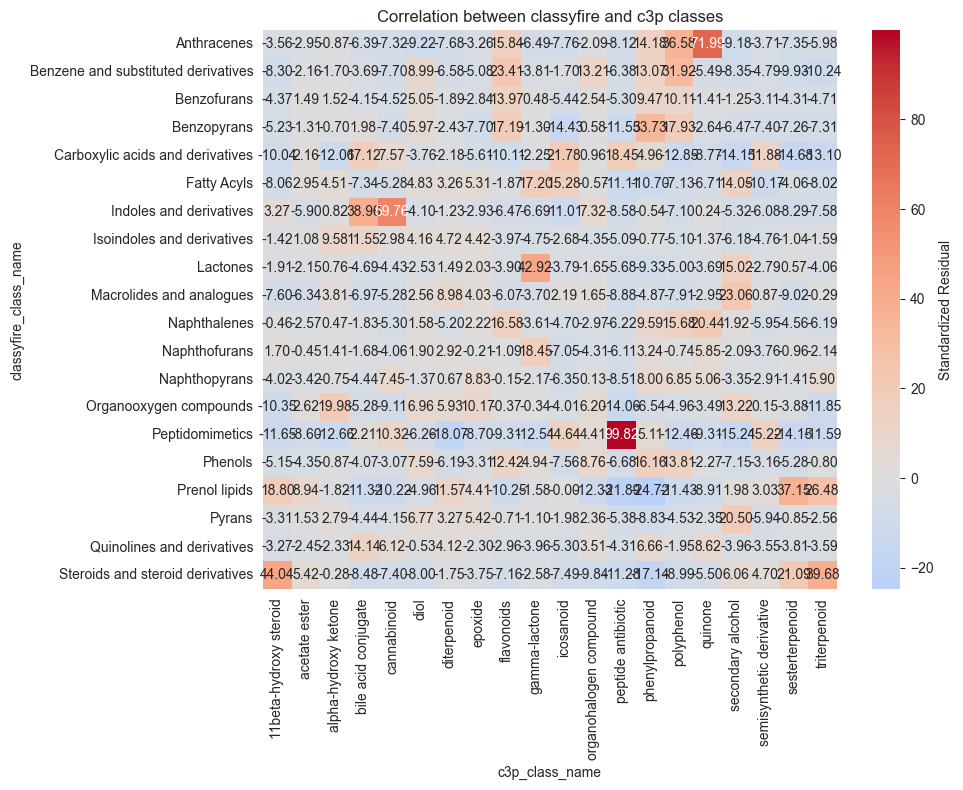

In [99]:
corrs = plot_correlation(merged_df, "classyfire_class_name", "c3p_class_name", title="Correlation between classyfire and c3p classes")

In [102]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def top_significant_pairs(df, col1, col2, N=20, M=20, top_k=20):
    """
    Return a DataFrame of the most positively significant (over-represented) 
    category pairs, based on standardized residuals from the chi-square test.
    
    1. Filter to top N categories in col1 and top M categories in col2 by frequency.
    2. Build contingency table.
    3. Perform chi2_contingency to get expected counts.
    4. Compute standardized residuals = (O - E) / sqrt(E).
    5. Return a table of pairs sorted by descending standardized residual.
    
    Args:
        df (pd.DataFrame): input data
        col1 (str): the name of the first categorical column
        col2 (str): the name of the second categorical column
        N (int): keep top N categories in col1
        M (int): keep top M categories in col2
        top_k (int): how many top pairs to return (sorted by largest positive standardized residual)
        
    Returns:
        pd.DataFrame: A DataFrame with columns:
                      [col1, col2, observed_count, expected_count, std_resid]
    """
    
    # 1. Identify top N categories in col1
    top_n_categories_col1 = df[col1].value_counts().nlargest(N).index
    # 2. Identify top M categories in col2
    top_m_categories_col2 = df[col2].value_counts().nlargest(M).index
    
    # 3. Filter the DataFrame to only those categories
    df_filtered = df[
        df[col1].isin(top_n_categories_col1) &
        df[col2].isin(top_m_categories_col2)
    ]
    
    # 4. Create a contingency table (observed counts)
    contingency_table = pd.crosstab(df_filtered[col1], df_filtered[col2])
    
    # 5. Perform chi2_contingency to get expected counts
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Overall Chi-square: {chi2:.4f}, p-value: {p:.2e}, dof: {dof}")
    
    # 6. Compute standardized residuals: (O - E) / sqrt(E)
    observed = contingency_table.values
    standardized_residuals = (observed - expected) / np.sqrt(expected)
    
    # Flatten into a long-format DataFrame of pairs
    rows = []
    row_categories = contingency_table.index
    col_categories = contingency_table.columns
    
    for i, row_cat in enumerate(row_categories):
        for j, col_cat in enumerate(col_categories):
            obs = observed[i, j]
            exp = expected[i, j]
            sr = standardized_residuals[i, j]
            rows.append({
                col1: row_cat,
                col2: col_cat,
                "observed_count": obs,
                "expected_count": exp,
                "std_resid": sr
            })
            
    result_df = pd.DataFrame(rows)
    
    # 7. Sort by descending standardized residual (show most over-represented pairs first)
    result_df.sort_values("std_resid", ascending=False, inplace=True)
    
    # Optionally take the top_k pairs
    top_pairs = result_df.head(top_k).reset_index(drop=True)
    
    return top_pairs


In [106]:
top_pairs = top_significant_pairs(merged_df, "classyfire_class_name", "c3p_class_name", N=100, M=100, top_k=100)
top_pairs.head(100)

Overall Chi-square: 342666.4721, p-value: 0.00e+00, dof: 9801


,classyfire_class_name,c3p_class_name,observed_count,expected_count,std_resid
0,Macrolides and analogues,macrolide,1071,55.489795,136.325698
1,Peptidomimetics,peptide antibiotic,1634,148.230787,122.034366
2,Polypeptides,polypeptide,189,3.869543,94.112661
3,Dihydrofurans,butenolide,232,7.773573,80.422296
4,Polypeptides,macromolecule,180,4.905257,79.057347
...,...,...,...,...,...
95,Lactams,alpha-amino acid,7,0.063688,27.485270
96,Pyridines and derivatives,alkaloid,46,2.550913,27.204003
97,5'-deoxyribonucleosides,ribonucleoside,9,0.107544,27.116229
98,Sphingolipids,beta-D-galactoside,27,0.928338,27.059239


In [107]:
top_pairs.head(100).to_csv("npatlas/top_pairs.csv", index=False)